# Mean vs Median Causal Effect

*An introduction to quantile regression.*

In A/B tests, a.k.a. [randomized controlled trials](https://en.wikipedia.org/wiki/Randomized_controlled_trial), we usually estimate the **average treatment effect (ATE)**: effect of a treatment (a drug, ad, product, ...) on an outcome of interest (a disease, firm revenue, customer satisfaction, ...), where the "average" is taken over the test subjects (patients, users, customers, ...). The ATE is a very useful quantity since it tells us the effect that we can expect if we were to treat a new subject with the same treatment.

However, sometimes we might be interested in quantities different from the average, such as the [**median**](https://en.wikipedia.org/wiki/Median). The median is an alternative measure of *central tendency* that is more robust to outliers and is often more informative with skewed distributions. More generally, we might want to estimate the effect for different [quantiles](https://en.wikipedia.org/wiki/Quantile) of the outcome distribution. A **common use-case** is studying the impact of a UI change on the loading time of a website: a slightly heavier website might translate in an imperceptible change for most users, but a big change for a few users with very slow connections. Another common use-case is studying the impact of a product change on a product that is bought by few people: do existing customers buy it more or are we attracting new customers?

These questions are hard to answer with linear regression that estimates the *average treatment effect*. A more suitable tool is **quantile regression** that can instead estimate the *median treatment effect*. In this article we are going to cover a brief introduction to quantile regression and the estimation of quantile treatment effects.

## Loyalty Cards and Spending

Suppose we were an **online store** and we wanted to increase sales. We decide to offer our customers a **loyalty card** that grants them discounts as they increase their spend in the store. We would like to assess if the loyalty card is effective in increasing sales so we run an **A/B test**: we offer the loyalty card on to a subset of our customers, at random.

I import the data generating process `dgp_fidelty()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).  To include not only code but also data and tables, I use [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *
from src.dgp import dgp_fidelty

Now, let's have a look at the data. We have information on $10.000$ customers, for whom we observe their `spend` and whether they were offered the `fidelty` card. We also observe some demographics, like `age` and `gender`.

In [2]:
df = dgp_fidelty().generate_data()
df.head()

,fidelty,spend,age,gender
0,1,0.0,30,Male
1,0,0.0,26,Male
2,1,0.0,27,Male
3,1,0.0,29,Male
4,1,0.0,23,Female


Interestingly, we notice that the outcome of interest, `spend`, seems to have a lot of zeros. Let's dig deeper.

## Mean vs Median

Before analyzing our experiment, let's have a look at our outcome variable, `spend`. Let' first inspect it using centrality measures. We have two main options: the **mean** and the **median**. 

First of all, what are they? The mean captures the average value, while the median captures the value in the middle of the distribution. In general, the mean is mathematically more tractable and easier to interpret, while the median is more robust to outliers. You can find plenty of articles online comparing the two measures and suggesting which one is appropriate and when. Let's have a look at the mean and median `spend`.

In [3]:
np.mean(df['spend'])

28.136224

In [4]:
np.median(df['spend'])

0.0

How do we interpret these two numbers? People spend on average 28\$ on our store. However, more than 50\% of people don't spend anything. As we can see, both measures are very informative and, to a certain extent, complementary. We can better understand the distribution of `spend` by plotting its histogram.

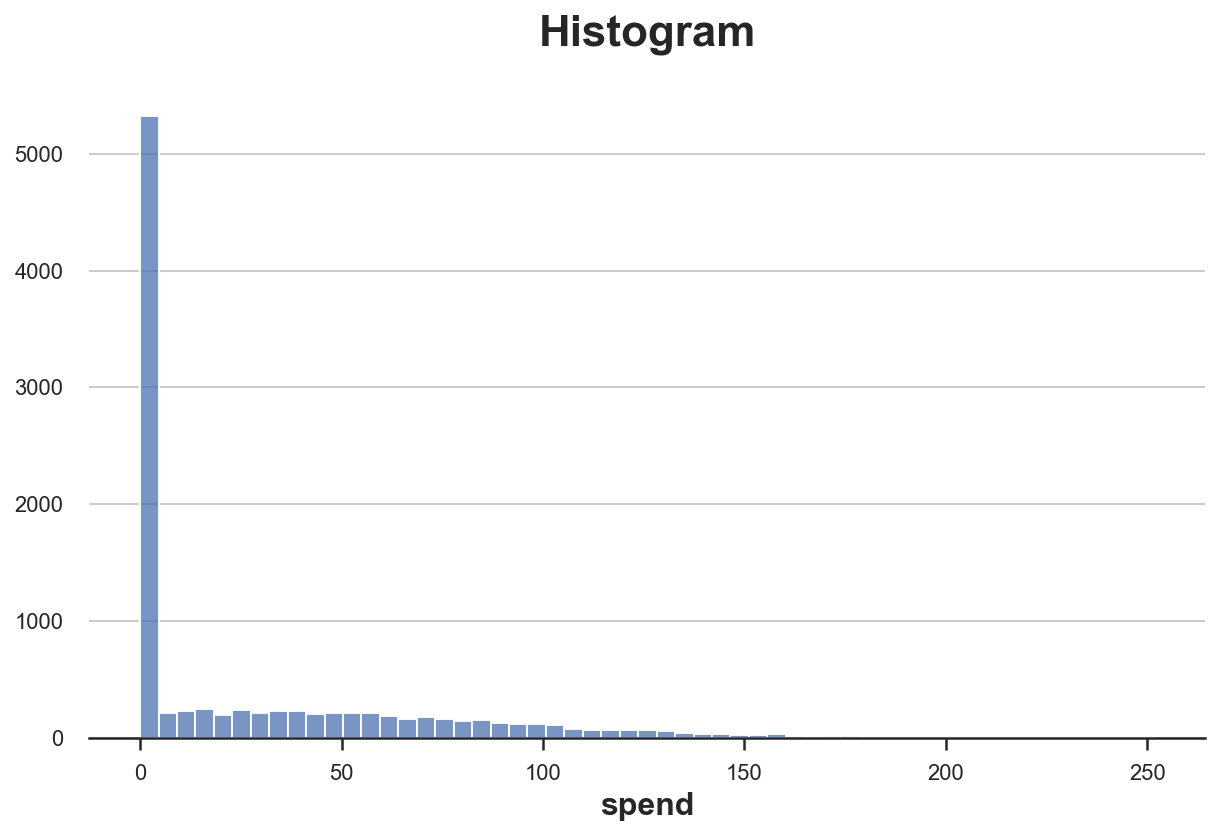

In [5]:
sns.histplot(data=df, x="spend").set(ylabel='', title='Histogram');

As previewed by the values of the mean and median, the distribution of `spend` is very skewed, with more than 5000 customers not spending anything.

One natural question then is: are we interested in the effect of the `fidelity` card on average `spend` or on median `spend`? The first would tell us if customers spend more on average, the second would tell us if the average customer spends more.

Linear regression can tell us the effect of the `fidelty` card on average `spend`. However, what can we do if we were interested in the effect of the `fidelty` card on median `spend` (or other quantiles)? The answer is **quantile regression**.

## Quantile Regression

With **linear regression**, we try to estimate the conditional expectation of an outcome variable $Y$ (`spend` in our example) with respect to one or more explanatory variables $X$ (`fidelty` in our example).

$$
\mathbb E \big[ Y \big| X \big]
$$

In other words, we want to find a function $f$ such that $f(X) = \mathbb E[Y]$. We do so, by solving the following minimization problem:

$$
\hat f(X) = \arg \min_{f} \mathbb E \big[ Y - f(X) \big]^2
$$

It can be shown that the function $f$ that solves this minimization is indeed the conditional expectation of $Y$, with respect to $X$.

Since $f(X)$ can be infinite dimensional, we estimate the following parametric form of $f(X)$:

$$
\hat \beta = \arg \min_{\beta} \mathbb E \big[ Y - \beta X \big]^2
$$

The linear form is not just convenient, but can be interpreted as the best local approximation of $f(x)$, referring to Taylor's expansion.

With **quantile regression**, we do the **same**. The only difference is that, instead of trying to estimate the conditional expectation of $Y$ with respect to $X$, we want to estimate the $q$-[quantile](https://en.wikipedia.org/wiki/Quantile) of $Y$ with respect to $X$.

$$
\mathbb Q_q \big[ Y \big| X \big]
$$

First of all, what is a **quantile**? The [Wikipedia definition](https://en.wikipedia.org/wiki/Quantile) says

> "In statistics and probability, quantiles are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities, or dividing the observations in a sample in the same way. Common quantiles have special names, such as quartiles (four groups), deciles (ten groups), and percentiles (100 groups)."

For example, the 0.1-quantile represents the value that sits on the right of 10% of the mass of the distribution. The median is the 0.5-quantile (or, equivalently, the $50^{th}$ percentile or the $5^{th}$ decile) and corresponds with the value in the center of the distribution. Let's see a simple example with a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). I plot the three quartiles that divide the data in four equally sized bins.

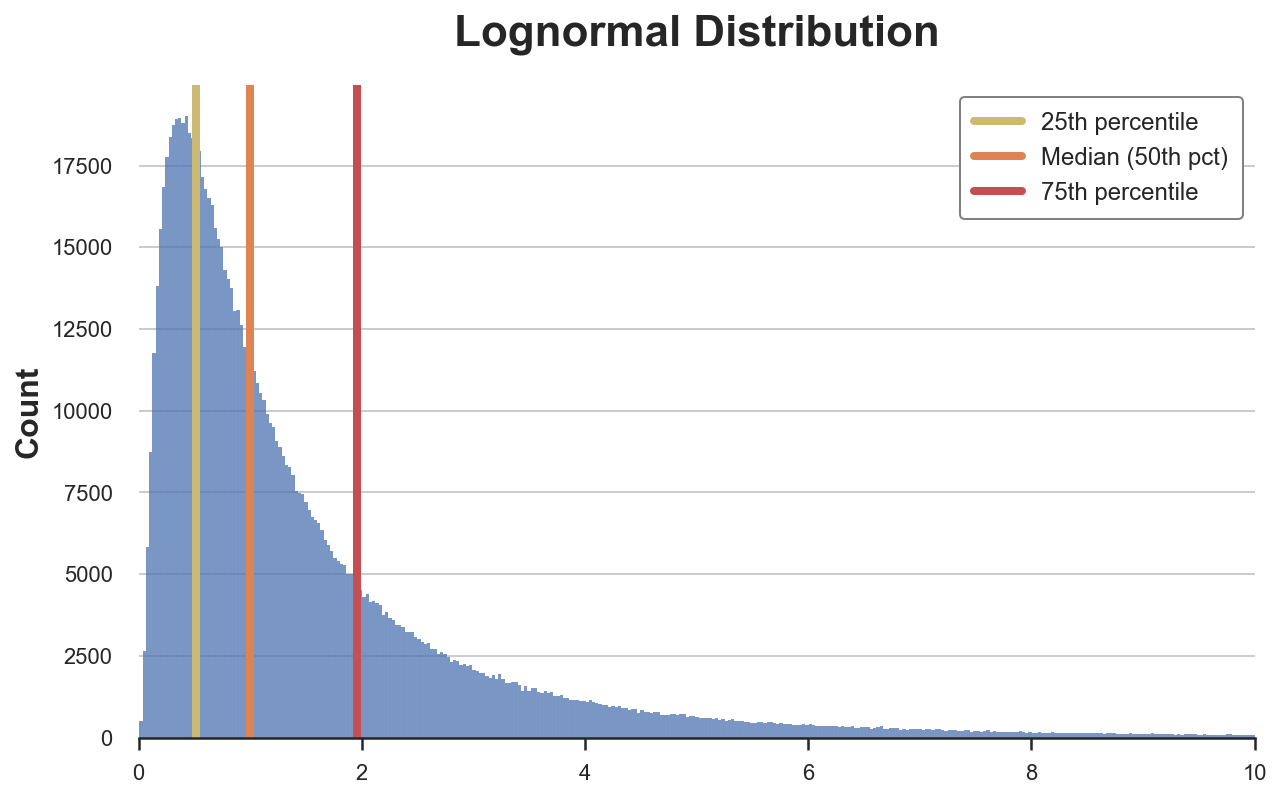

In [70]:
data = np.random.lognormal(0, 1, 1_000_000);
sns.histplot(data).set(title='Lognormal Distribution', xlim=(0,10))
plt.axvline(x=np.percentile(data, 25), c='C8', label='25th percentile')
plt.axvline(x=np.median(data), c='C1', label='Median (50th pct)')
plt.axvline(x=np.percentile(data, 75), c='C3', label='75th percentile')
plt.legend();

As we can see, the three quartiles divide the data into four bins, of equal size.

So, what is the **objective** of quantile regression? The objective is to find a function $f$ such that $f(X) = F^{-1}(y_q)$, where $F$ is the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of $Y$ and $y_q$ is the $q$-quantile of the distribution of $Y$. 


How do we do this? It can be shown with a little linear algebra that we can obtain the quantile as the solution of the following minimization problem:

$$
\hat f(X) = \arg \min_{f} \mathbb E \big[ \rho_q (Y - f(X)) \big] = \arg \min_{f} (1-q) \int_{-\infty}^{f(x)} (y - f(x)) \text{d} F(y) + q \int_{f(x)}^{\infty} (y - f(x)) \text{d} F(y)
$$

What is the **intuition** behind this objective function?

The idea is that we can interpret the equation as follows

$$
\mathbb E \big[ \rho_q (Y - f(X)) \big] = (1-q) \underset{\color{red}{\text{mass of distribution below }f(x)}}{\int_{-\infty}^{f(x)} (y - f(x)) \text{d} F(y)} + q \underset{\color{red}{\text{mass of distribution above }f(x)}}{\int_{f(x)}^{\infty} (y - f(x)) \text{d} F(y)} \overset{\color{blue}{\text{if } f(x) = y_q}}{=} - (1-q) q + q (1-q) = 0
$$

So that, when $f(X)$ corresponds with the quantile $y_q$, the value of the objective function is zero.

Exactly as before, we can estimate a **parametric form** of $f$ and, exactly as before, we can interpret it as a best local approximation (not trivially though, see [Angrist, Chernozhukov, and Fernández-Val (2006)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00671.x)).

$$
\hat \beta_q = \arg \min_{\beta} \mathbb E \big[ \rho_q (Y - \beta X ) \big]
$$

Where we wrote $\hat \beta_q$ to indicate that this is the coefficient for the best linear approximation of the conditional $q$-quantile function.

## Estimation

How do we **estimate** e quantile regression?

The main problem is that, in order to estimate $\beta_q$, we need to know the distribution of $Y$. This is not required with linear regression.

The [statsmodels](https://www.statsmodels.org/stable/index.html) package does everything thanks to the [`quantreg()`](https://www.statsmodels.org/dev/generated/statsmodels.regression.quantile_regression.QuantReg.html) function. We just need to specify the quantile $q$ when we fit the model.

In [58]:
smf.quantreg("spend ~ fidelty", data=df).fit(q=0.5).summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.668e-07,0.153,5.66e-06,1.000,-0.300,0.300
fidelty,3.4000,0.217,15.649,0.000,2.974,3.826


Quantile regression estimates a positive effect of the `fidelty` card on **median** customer `spend`. How does this estimate compare with linear regression?

In [6]:
smf.ols("spend ~ fidelty", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,25.6583,0.564,45.465,0.000,24.552,26.765
fidelty,4.9887,0.801,6.230,0.000,3.419,6.558


The estimated coefficient is higher: `fidelty` cards increase **mean** `spend` more than median `spend`. 

Can we condition on other variables? We suspect that `spend` is also affected by other variables and we want to increase the precision of our estimate by also conditioning the analysis on `age` and `gender`. We can just add the variables to the `quantreg()` model. 

In [9]:
smf.quantreg("spend ~ fidelty + age + gender", data=df).fit(q=0.5).summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-50.5353,1.053,-47.977,0.000,-52.600,-48.471
gender[T.Male],-20.2963,0.557,-36.410,0.000,-21.389,-19.204
fidelty,4.5747,0.546,8.374,0.000,3.504,5.646
age,2.3663,0.026,92.293,0.000,2.316,2.417


The coefficient of `fidelty` increases when we condition the analysis on `age` and `gender`. This is true also for linear regresssion.

In [60]:
smf.ols("spend ~ fidelty + age + gender", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-57.4466,0.911,-63.028,0.000,-59.233,-55.660
gender[T.Male],-26.3170,0.482,-54.559,0.000,-27.262,-25.371
fidelty,3.9101,0.473,8.272,0.000,2.983,4.837
age,2.7688,0.022,124.800,0.000,2.725,2.812


There is one last (but definitely not least) thing we haven't mentioned yet: **inference**. How do we compute confidence intervals and p-values for our estimates in quantile regression?

## Inference

The asymptotic variance of the estimate $a$ of the quantile $q$ of a distribution $F$ is given by

$$
AVar(a) = q(1-q) f^{-2}(a)
$$

where $f$ is the [density function](https://en.wikipedia.org/wiki/Probability_density_function) of $F$. This expression can be decomposed into **two components**: $q(1-q)$ and $f^{-2}(a)$.

The first component, $q(1-q)$, basically tells us that the variance of a quantile is higher the more the quantile is closer to the center. Why is that so? First, we need to think about when the quantile of a point changes in response to a change in the value of a second point. The quantile changes when the second point swaps from left to right (or viceversa) of the first point. This is intuitively very easy if the first point lies in the middle of the distribution, but very hard if it lies at the extreme.

The second component, $f^{-2}(a)$, instead tells us that this side swapping is more likely if the first point is surrounded by a lot of points. 

Importantly, estimating the variance of a quantile requires an estimate of the whole distribution of $Y$. This is done via approximation and can be computationally very intensive. However, alternative procedures like the bootstrap or the [bayesian bootstrap](https://towardsdatascience.com/6ca4a1d45148) are always available.

## Interpretation

The **interpretation** of linear regression coefficients is straightforward: each coefficient is the derivative of the conditional expectation function $\mathbb E[Y|X]$ with respect to one dimension of $X$. In our case, we can interpret the regression coefficient of `fidelty` as the average spend increase from being offered a fidelty card. Crucially, here "average" means that this holds true for *each customer*, on average.

However, the interpretation of quantile regression coefficients is **tricky**. Before, we were tempted to say that the `fidelty` card increases the spend of the median customer by 3.4\$. But **what does it mean**? Is it the same median customer that spends more or do we have a different median customer? This might seem like a philosophical issue but has important implications on reporting of quantile regression results. In the first case, we are making a statement that, as for the interpretation of linear regression coefficients, applies to a *single individual*. In the second case, we are making a statement about the *distribution*. 

[Chernozhukov and Hansen (2005)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2005.00570.x) show that a strong but helpful assumption is **rank invariance**: assuming that the treatment **does not shift** the relative composition of the distribution. In other words, if we rank people by `spend` before the experiment, we assume that this ranking is not affected by the introduction of the `fidelty` card. If I was spending less than you before, I might spend more afterwards, but still less than you (for any two people).

Under this assumption, we can interpret the quantile coefficients as **marginal effects for single individuals** sitting at different points of the outcome distribution, as in the first interpretation provided above. Moreover, we can report the treatment effect for many quantiles and interpret each one of them as a local effect for a different individual. Let's plot the distribution of treatment effects, for different quantiles of `spend`.

In [67]:
def plot_quantile_TE(df, formula, q, varname):
    df_results = pd.DataFrame()
    for q in np.arange(q, 1-q, q):
        qreg = smf.quantreg(formula, data=df).fit(q=q)
        temp = pd.DataFrame({'q': [q],
                             'coeff': [qreg.params[varname]], 
                             'std': [qreg.bse[varname]],
                             'ci_lower': [qreg.conf_int()[0][varname]],
                             'ci_upper': [qreg.conf_int()[1][varname]]})
        df_results = pd.concat([df_results, temp]).reset_index(drop=True)
    
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(data=df_results, x='q', y='coeff')
    ax.fill_between(data=df_results, x='q', y1='ci_lower', y2='ci_upper', alpha=0.1);
    plt.axhline(y=0, c="k", lw=2, zorder=1)
    ols_coeff = smf.ols(formula, data=df).fit().params[varname]
    plt.axhline(y=ols_coeff, ls="--", c="C1", label="OLS coefficient", zorder=1)
    plt.legend()
    plt.title("Estimated coefficient, by quantile")

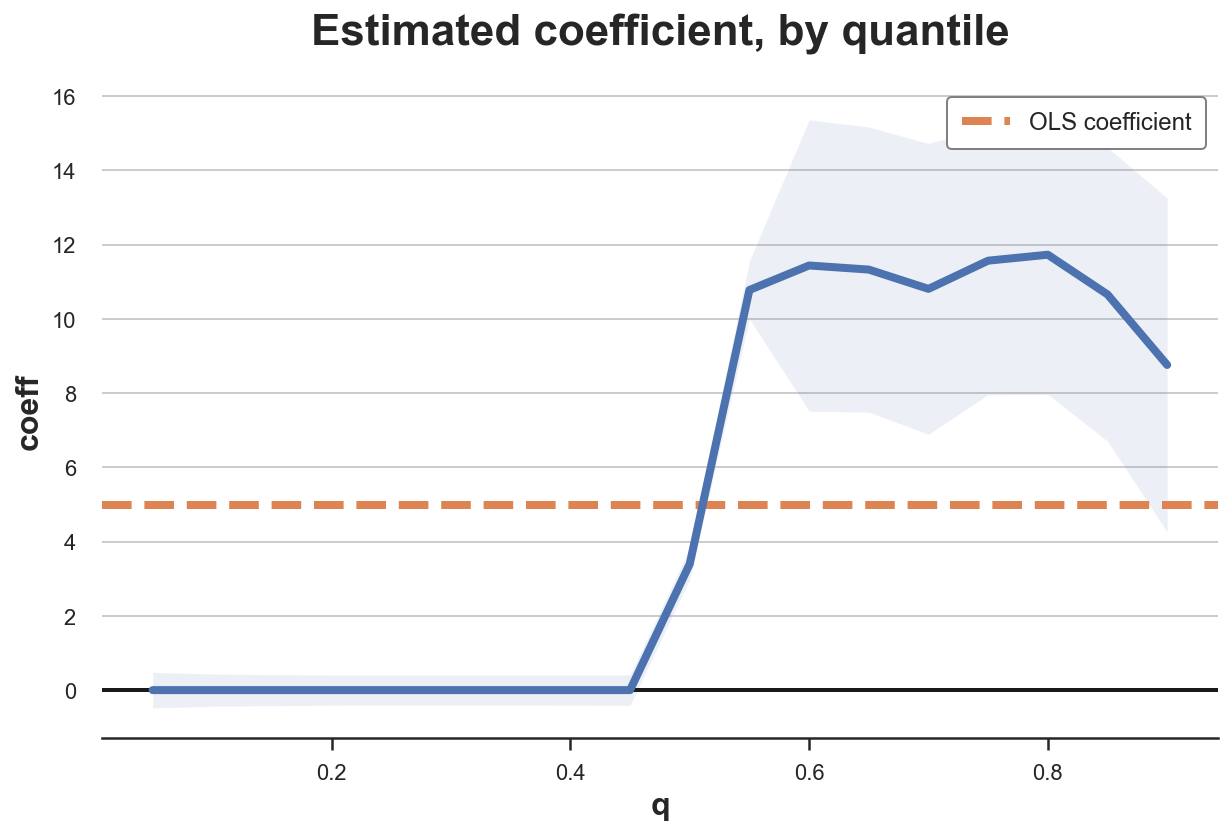

In [68]:
plot_quantile_TE(df, formula="spend ~ fidelty", varname='fidelty', q=0.05)

This plot is extremely **insightful**: for almost half of the customers, the `fidelty` card has no effect. On the other hand, customers that were already spending something end up spending even more (around 10/12$ more). This is a very powerful insight that we would have missed with linear regression.

We can repeat the same exercise, conditioning the analysis on `gender` and `age`.

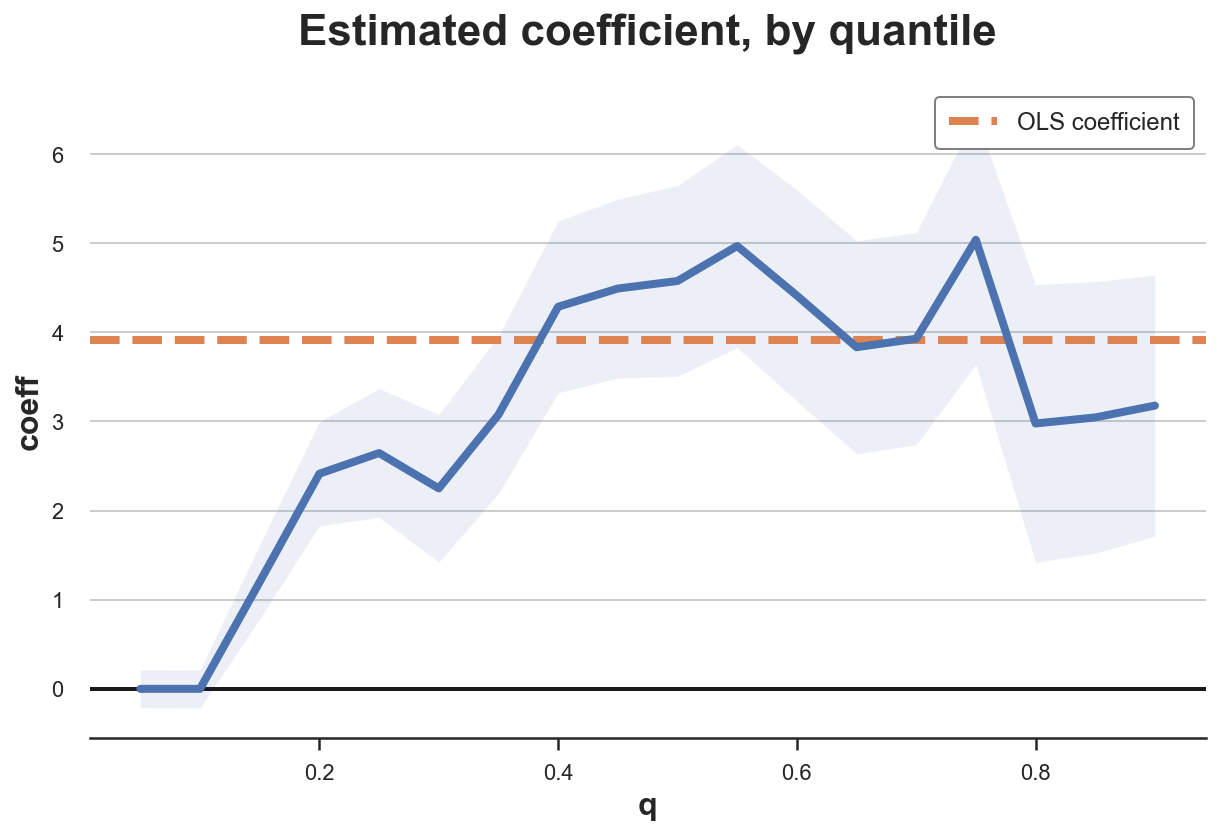

In [69]:
plot_quantile_TE(df, formula="spend ~ fidelty + age + gender", varname='fidelty', q=0.05)

Conditioning on other covariates removes a lot of the heterogeneity in treatment effects. The `fidelty` card increases spending for most people, it's demographic characteristics that are responsible for no spending to begin with.

## Conclusion

In this article, we have seen a different **causal estimand**: median treatment effects. How does it compare with the average treatment effect that we usually estimate? The pros and cons are closely related to the pros and cons of the median with respect to the mean as a measure of **central tendency**. Median treatment effects are more informative on what is the effect on the average subject and are more robust to outliers. However, they are extremely more computationally intensive and they require strong assumptions for identification, such as rank invariance.

### References

[1] R. Koenker, K. Hallock, [Quantile Regression](https://www.aeaweb.org/articles?id=10.1257/jep.15.4.143), (2001), *Journal of Economic Perspectives*.

[2] V. Chernozhukov, C. Hansen, [An IV Model of Quantile Treatment Effects](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2005.00570.x) (2005), *Econometrica*.

[3] J. Angrist, V. Chernozhukov, I. Fernández-Val, [Quantile Regression under Misspecification, with an Application to the U.S. Wage Structure](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1468-0262.2006.00671.x) (2006), *Econometrica*.

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)
- [The Bayesian Bootstrap](https://towardsdatascience.com/6ca4a1d45148)
- [Goodbye Scatterplot, Welcome Binned Scatterplot](https://towardsdatascience.com/a928f67413e4)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/quantile_reg.ipynb